# COVID-19 Testing Process Simulation Using R Simmer
#### R Simmer Reference - https://r-simmer.org/reference/index.html

## Task 0 - Load Libraries, Functions & Introduction

In [ ]:
pkgs = c("simmer","simmer.plot", "simmer.bricks","data.table") 
check = pkgs %in% installed.packages()
if(!check[1]) install.packages("simmer")
if(!check[2]) install.packages("simmer.plot")
if(!check[3]) install.packages("simmer.bricks")
if(!check[4]) install.packages("data.table")
rm(pkgs, check)
library(simmer)
library(simmer.plot)
library(simmer.bricks)
library(data.table)

# FUser Defined Function To Log Both Resource & Activity Name (Using Attributes) 
VisitStep <- function(activity, duration = 0, resource = "0", n = 0) {
  t1 = trajectory() %>% set_attribute(activity, 0)     # enter the queue
  t2 = trajectory() %>% seize(resource, n)             # seize the resource
  t3 = trajectory() %>% set_attribute(activity, 1)     # begin the activity
  t4 = trajectory() %>% timeout(duration)              # activity duration
  t5 = trajectory() %>% release(resource, n)           # release the resource
  t6 = trajectory() %>% set_attribute(activity, 2)     # leave the activity
  if(resource == "0") return(join(t1,t3,t4,t6)) 
  return(join(t1,t2,t3,t4,t5,t6)) 
}

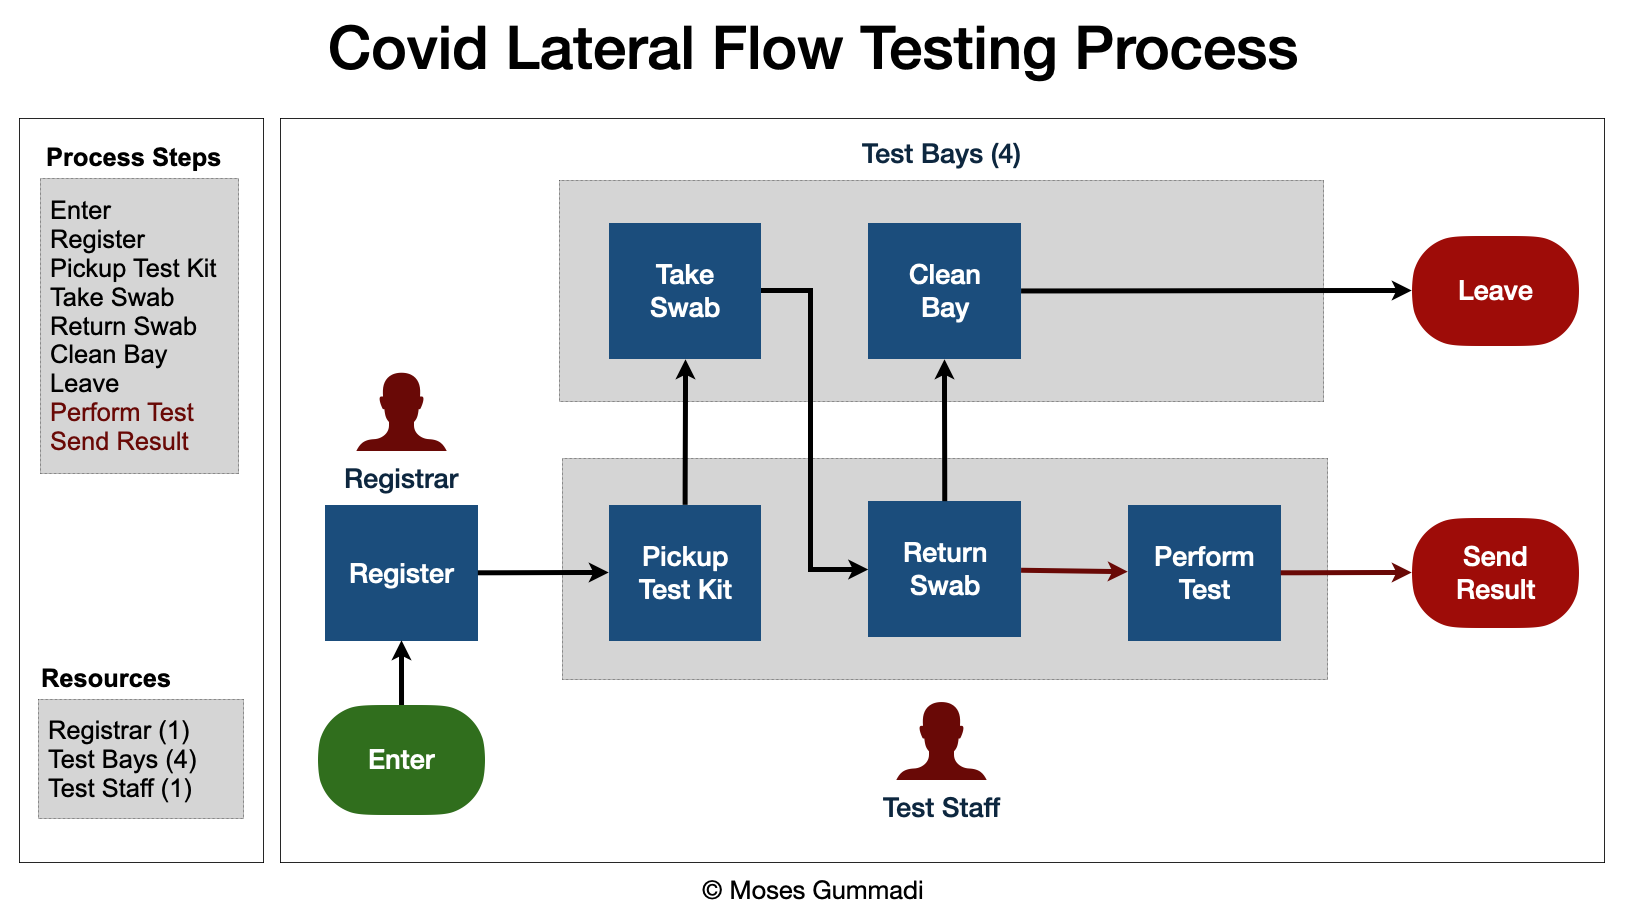

## Task 1 - Create Statistical Variables For Simulation

#### Parameters Required For Simulation.

In [ ]:
Arrival = function() {return(rexp(1, 1/2))}            # Inter Arrival Time - Exponential Distribution
RegTime = function() {return(runif(1, 0.5, 1.5))}      # Registration Time - Uniform Distribution
SwabTime = function() {return(rnorm(1, 2, 1/3))}       # Swab Taking Time - Normal Distribution
CleanTime = function() {return(rnorm(1, 2, 0.33))}     # Bay Cleaning Time - Normal Distribution
TestTime = function() {return(rnorm(1, 1.5, 0.25))}    # Test Process Time - Normal Distribution
SimTime = 240

In [ ]:
rexp(5, 1/3); mean(rexp(1000, 1/3)); hist(rexp(1000, 1/3))

#### Task 1 Exercise -  Normal Distribution (Mean = 0, Std Dev = 1) Display 5 Values, Plot Histogram (N = 500)

In [ ]:
# Write Task 1 Exercise Code Below This Line
hist(rnorm(1000,0,1))

In [ ]:
# This is how to find help for R functions
help(rexp)

## Task 2 - Define Trajectory, Resources, Arrivals

#### Define Process Trajectory

In [ ]:
# Simplified Trajectory (For Demonstration)
t = trajectory() %>%

  # Registration Step
  seize("Registrar", 1) %>%  
  timeout(RegTime) %>%
  release("Registrar",1) %>%

  # Pickup Test Kit
  seize("Test Staff", 1) %>%   
  timeout(0.5) %>%
  release("Test Staff", 1) %>% 

  # Take Swab, Return Swab & Clean Bay Steps
  seize("Test Bay", 1) %>%  
  timeout(SwabTime) %>%
  timeout(0.5) %>%       
  timeout(CleanTime) %>%
  release("Test Bay",1) 

#### Define Resources & Arrivals

In [ ]:
# Create Simulation Environment
env <- simmer()

# Define Resources
env %>% add_resource("Registrar", 1)
env %>% add_resource("Test Bay", 4)
env %>% add_resource("Test Staff", 1)

# Generate Arrivals
env %>% add_generator("Student", t, Arrival)

In [ ]:
print(t); plot(t)

#### Task 2 Exercise - Update Trajectory Using "Test Staff" Resource For "Return Swab" Activity

In [ ]:
# Write Task 2 Exercise Code Below This Line

t = trajectory() %>%

  # Registration Step
  seize("Registrar", 1) %>%  
  timeout(RegTime) %>%
  release("Registrar",1) %>%

  # Pickup Test Kit
  seize("Test Staff", 1) %>%   
  timeout(0.5) %>%
  release("Test Staff", 1) %>% 

  # Take Swab, Return Swab & Clean Bay Steps
  seize("Test Bay", 1) %>%  
  timeout(SwabTime) %>%
  seize("Test Staff", 1) %>% 
  timeout(0.5) %>%  
  release("Test Staff", 1) %>% 
  timeout(CleanTime) %>%
  release("Test Bay",1) 

print(t)

## Task 3 - Run Simulation, Store & Display Results

In [ ]:
# Run Simulation
env %>% run(until = SimTime)

# Store Results
resources = get_mon_resources(env)
arrivals = get_mon_arrivals(env, per_resource = TRUE)

In [ ]:
# Display Arrivals Table
head(arrivals)

In [ ]:
# Display path of single individual
subset(arrivals, name == "Student15")

#### Task 3 Exercise:<br> &emsp; A.  Store "arrivals" Results With 'per_resource = FALSE'.<br> &emsp; B. Plot Historgram of Flow Time

In [ ]:
# Write Task 3 Exercise Code Below This Line
# Hint: flowtime = arrivals$end_time - arrivals$start_time

## Task 4 - Plot Charts & Interpret Results

In [ ]:
plot(resources, metric = "utilization", c("Registrar", "Test Staff", "Test Bay") )

In [ ]:
# Plots
plot(resources, metric = "usage", "Registrar")

In [ ]:
plot(resources, metric = "usage", "Registrar", items = "server", steps = TRUE)

#### Task 4 Exercise - Plot the Usage of "Test Bay" with Steps = TRUE

In [ ]:
# Write Task 3 Exercise Code Below This Line

## Task 5 - Advanced Trajectory - Parallel Paths

In [ ]:
# Reset After Changes Made To Previous Runs
reset(env)

In [ ]:
# Advanced Trajectory - Parallel Paths 
# Use "Visit" instead of Seize, Timeout, Release

t1 = trajectory() %>%

  # Registration Step
  visit("Registrar", RegTime, 1) %>%

  # Pickup Test Kit
  visit("Test Staff", 0.5, 1) %>%

  # Take Swab (Note - Test Bay Not Released)
  seize("Test Bay", 1) %>%  
  timeout(SwabTime) %>%
 
  # Return Swab
  visit("Test Staff", 0.5, 1) 

# Here the path splits into parallel routes

t2 = trajectory() %>%

  # Clean Bay
  visit("Registrar", CleanTime, 1) %>%

  # Release Test Bay (seized in t1)
  release("Test Bay",1) 

t3 = trajectory() %>%
  # Perform Test
  visit("Test Staff", TestTime, 1)

# Join Trajectories
t = trajectory() %>%

  # path before the split
  join(t1) %>%

  # split into parallel paths t2, t3
  clone(n = 2, t2, t3) %>%

  # join parallel paths 
  synchronize(wait = TRUE)

print(t)

In [ ]:
# Create Environment, Add Resources, Generator (Arrivals)
env <- simmer() %>%
       add_resource("Registrar", 1)  %>%
       add_resource("Test Bay", 4)   %>%
       add_resource("Test Staff", 1) %>%
       add_generator("Student", t, Arrival)

# Run Simulation
env %>% run(until = SimTime)

# Store Results
resources = get_mon_resources(env)
arrivals = get_mon_arrivals(env, per_resource = TRUE)

In [ ]:
plot(resources, metric = "utilization", c("Registrar", "Test Staff", "Test Bay") )

In [ ]:
plot(arrivals, metric="flow_time")

#### Task 5 Exercise - Plot the Waiting Time of Arrivals (metric = "waiting_time)

In [ ]:
# Write Task 5 Exercise Code Below This Line

## Task 6 - Log Activity Names -  "VisitStep" Function

In [ ]:
# Student Trajectory - Alternative Approach (Easier)
# "VisitStep" is a user defined function 
# VisitStep(Activity_Name, Duration, Resource, Res_Qty)
# VisitStep(Activity_Name, Duration)

t1 = join(
  VisitStep("Enter", 0),
  VisitStep("Register", RegTime, "Registrar", 1),
  VisitStep("Pick TestKit", 0.25, "Test Staff", 1),
  trajectory () %>% seize("Test Bay", 1),
  VisitStep("Take Swab", SwabTime),
  VisitStep("Return Swab", 0.25, "Test Staff", 1)
  )

t2 = join(
  VisitStep("Clean Bay", CleanTime),
  trajectory () %>% release("Test Bay", 1)
  )

t3 = VisitStep("Clean Bay", TestTime, "Test Staff", 1)  


# Join Trajectories
t = trajectory() %>%

  # path before the split
  join(t1) %>%

  # split into parallel paths t2, t3
  clone(n = 2, t2, t3) %>%

  # join parallel paths 
  synchronize(wait = TRUE)

print(t)

#### **** Use "mon = 2" in add_generator function to log Activity Names ***

In [ ]:
# Create Environment, Add Resources, Generator (Arrivals)
env <- simmer() %>%
       add_resource("Registrar", 1)  %>%
       add_resource("Test Bay", 4)   %>%
       add_resource("Test Staff", 1) %>%
       add_generator("Student", t, Arrival, mon = 2) # mon = 2 to log attributes

# Run Simulation
env %>% run(until = SimTime)

# Store Results
resources = get_mon_resources(env)
arrivals = get_mon_arrivals(env, per_resource = TRUE)
subset(arrivals, name == "Student15")

#### Create Event Log With Activity Names

In [ ]:
# Create Event Log
eventlog = dcast(data.table(get_mon_attributes(env)), name + key ~ value, value.var = "time")
names(eventlog) = c("ID","Activity", "Arrival","Begin","Finish")
eventlog = eventlog[order(Arrival)]
print(eventlog)

In [ ]:
eventlog[ID == "Student15"]

In [ ]:
plot(resources, metric = "utilization", c("Registrar", "Test Staff", "Test Bay") )

In [ ]:
plot(arrivals, metric="flow_time")